# Main Code

Hudson Bay UDE: Robust L1 vs L2 Comparison

=== TRIAL 1/30 ===

--- Starting Training for: L2 ---
  Final Loss: 0.07105
  Estimated p1: 0.3732, p2: 0.9335

--- Starting Training for: L1 ---
  Final Loss: 0.01636
  Estimated p1: 0.7605, p2: 0.9400

=== TRIAL 2/30 ===

--- Starting Training for: L2 ---
  Final Loss: 0.07100
  Estimated p1: 0.3712, p2: 0.9364

--- Starting Training for: L1 ---
  Final Loss: 0.09740
  Estimated p1: 0.1212, p2: 1.3718

=== TRIAL 3/30 ===

--- Starting Training for: L2 ---
  Final Loss: 0.07102
  Estimated p1: 0.3661, p2: 0.9323

--- Starting Training for: L1 ---
  Final Loss: 0.02289
  Estimated p1: 0.7081, p2: 0.9470

=== TRIAL 4/30 ===

--- Starting Training for: L2 ---
  Final Loss: 0.07166
  Estimated p1: 0.4044, p2: 1.0617

--- Starting Training for: L1 ---
  Final Loss: 0.09286
  Estimated p1: 0.5029, p2: 1.3515

=== TRIAL 5/30 ===

--- Starting Training for: L2 ---
  Final Loss: 0.07101
  Estimated p1: 0.3645, p2: 0.9162

--- Starting Training for: L

/tmp/ipykernel_126605/1028930623.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_126605/1028930623.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_126605/1028930623.py:328: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)


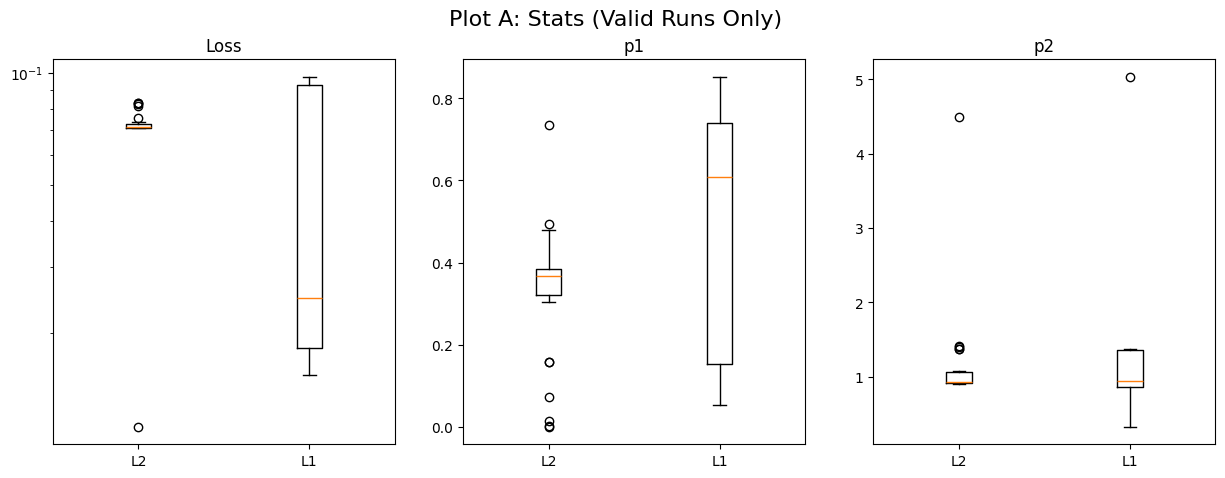

/tmp/ipykernel_126605/1028930623.py:45: RuntimeWarning: Mean of empty slice
  bootstrap_means[i] = np.nanmean(sample, axis=0)


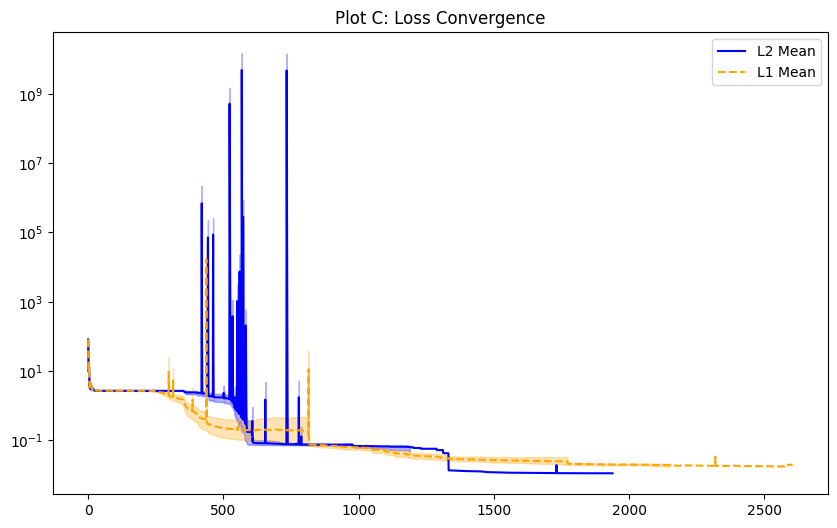

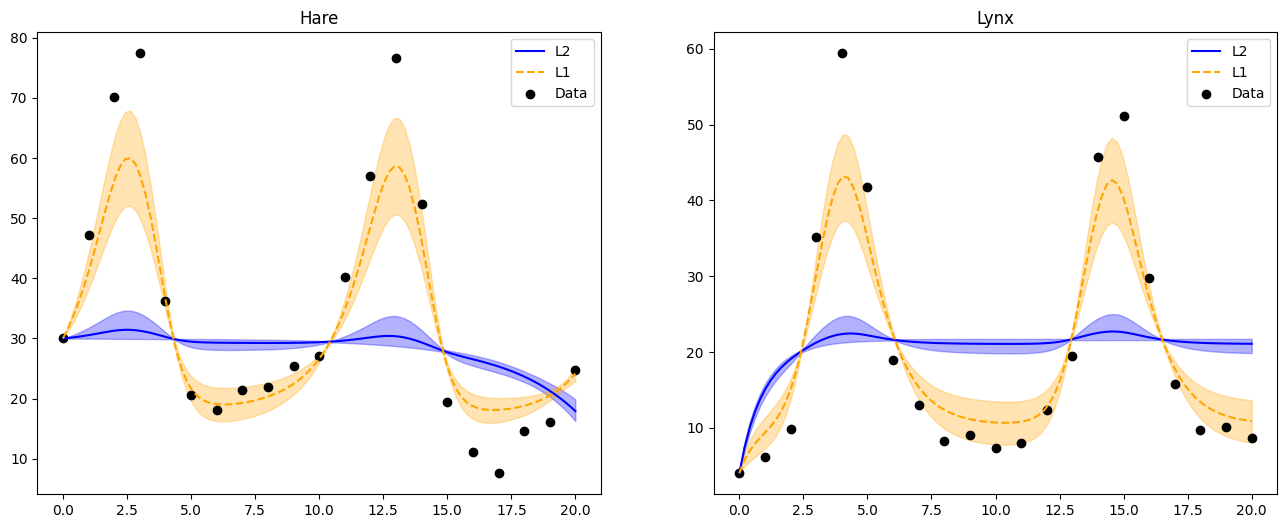

In [ ]:
# --- UTILITY FUNCTION FOR PADDING AND NOISE ---

def pad_loss_histories(history_list):
    """Pads a list of loss history arrays with NaNs to the maximum length."""
    if not history_list:
        return np.array([])
        
    max_len = max(len(h) for h in history_list)
    
    padded_histories = []
    for h in history_list:
        padding_size = max_len - len(h)
        padded = np.pad(h, (0, padding_size), 'constant', constant_values=np.nan)
        padded_histories.append(padded)
        
    return np.array(padded_histories)

# --- BOOTSTRAP PARAMETERS ---
N_BOOTSTRAP = 1000 
ALPHA = 0.95 

def bootstrap_ci(data_array, n_bootstrap=N_BOOTSTRAP, alpha=ALPHA):
    """Calculates Mean and 95% CI, ignoring NaNs."""
    # Filter out completely NaN rows (failed runs) before bootstrapping
    valid_mask = ~np.all(np.isnan(data_array.reshape(data_array.shape[0], -1)), axis=1)
    valid_data = data_array[valid_mask]
    
    n_runs = valid_data.shape[0]
    if n_runs == 0:
        return None, None, None
        
    bootstrap_means = np.zeros((n_bootstrap,) + valid_data.shape[1:])
    
    for i in range(n_bootstrap):
        indices = np.random.choice(n_runs, size=n_runs, replace=True)
        sample = valid_data[indices]
        bootstrap_means[i] = np.nanmean(sample, axis=0) 
    
    final_mean = np.nanmean(bootstrap_means, axis=0)
    lower_ci = np.percentile(bootstrap_means, (1 - alpha) / 2 * 100, axis=0)
    upper_ci = np.percentile(bootstrap_means, (1 + alpha) / 2 * 100, axis=0)
    
    return final_mean, lower_ci, upper_ci

# --- SEED MANAGEMENT ---
def reset_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def add_noise_to_nn_weights(model, sigma=1e-4):
    with torch.no_grad():
        for name, param in model.nn_model.named_parameters():
            noise = torch.randn_like(param) * sigma
            param.add_(noise)

GLOBAL_SEED = 5443
reset_seeds(GLOBAL_SEED) 

print("="*70)
print("Hudson Bay UDE: Robust L1 vs L2 Comparison")
print("="*70)

# ==============================================================================
# 1. DATA PREPROCESSING
# ==============================================================================
# raw data from https://github.com/ChrisRackauckas/universal_differential_equations/tree/master/LotkaVolterra
raw_data = np.array([
    [1900, 30.0, 4.0], [1901, 47.2, 6.1], [1902, 70.2, 9.8], [1903, 77.4, 35.2],
    [1904, 36.3, 59.4], [1905, 20.6, 41.7], [1906, 18.1, 19.0], [1907, 21.4, 13.0],
    [1908, 22.0, 8.3], [1909, 25.4, 9.1], [1910, 27.1, 7.4], [1911, 40.3, 8.0],
    [1912, 57.0, 12.3], [1913, 76.6, 19.5], [1914, 52.3, 45.7], [1915, 19.5, 51.1],
    [1916, 11.2, 29.7], [1917, 7.6, 15.8], [1918, 14.6, 9.7], [1919, 16.2, 10.1],
    [1920, 24.7, 8.6]
])

t_np = raw_data[:, 0] - raw_data[0, 0] 
X_np = raw_data[:, 1:] 
X_data_denorm = X_np 
scale_vector = np.max(X_np, axis=0)
X_norm = X_np / scale_vector

t = torch.tensor(t_np, dtype=torch.float32)
X = torch.tensor(X_norm, dtype=torch.float32)

# ==============================================================================
# 2. DEFINE THE NEURAL NETWORK (UDE)
# ==============================================================================

class RBF(nn.Module):
    def forward(self, x):
        return torch.exp(-(x**2))

class UDE_Net(nn.Module):
    def __init__(self):
        super(UDE_Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 5), RBF(),
            nn.Linear(5, 5), RBF(),
            nn.Linear(5, 5), nn.Tanh(),
            nn.Linear(5, 2)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.05)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

class HybridODE(nn.Module):
    def __init__(self, nn_model):
        super(HybridODE, self).__init__()
        self.nn_model = nn_model
        self.p1 = nn.Parameter(torch.tensor(0.5)) 
        self.p2 = nn.Parameter(torch.tensor(0.5))

    def forward(self, t, u):
        # FIX 1: Constraint to prevent unphysical states (Negative Populations)
        u_constrained = torch.relu(u) 
        nn_out = self.nn_model(u_constrained)
        
        x, y = u[0], u[1]
        
        # FIX 2: Enforce Positive Rates using torch.abs()
        # This prevents p1 and p2 from becoming negative and destabilizing the system
        p1_abs = torch.abs(self.p1)
        p2_abs = torch.abs(self.p2)
        
        dxdt = p1_abs * x + nn_out[0]
        dydt = -p2_abs * y + nn_out[1]
        
        return torch.stack([dxdt, dydt])

ude_net_init = UDE_Net()
model_init = HybridODE(ude_net_init)
initial_state = deepcopy(model_init.state_dict()) 

# ==============================================================================
# 3. LOSS FUNCTIONS
# ==============================================================================

def get_batch_indices(total_len, group_size):
    starts = np.arange(0, total_len - 1, group_size)
    segments = []
    for s in starts:
        e = min(s + group_size + 1, total_len)
        if e - s > 1:
            segments.append((s, e))
    return segments

# FIX 3: Use 'dopri5' solver instead of 'rk4'. 
# 'dopri5' is adaptive and handles stiff equations better, reducing NaNs.
SOLVER_METHOD = 'dopri5' 

def multiple_shooting_loss(model, t, X_target, group_size=5, l1_w=0.0, l2_w=0.0):
    segments = get_batch_indices(len(t), group_size)
    total_data_loss = 0.0
    
    for start, end in segments:
        t_seg = t[start:end]
        u0 = X_target[start] 
        # Adaptive solvers need rtol/atol to control step size
        pred = odeint(model, u0, t_seg, method=SOLVER_METHOD, rtol=1e-5, atol=1e-5) 
        target = X_target[start:end]
        total_data_loss += torch.sum((pred - target)**2)
        
    l1_reg = 0.0
    l2_reg = 0.0
    if l1_w > 0.0 or l2_w > 0.0:
        for param in model.nn_model.parameters():
            if l1_w > 0.0: l1_reg += torch.sum(torch.abs(param))
            if l2_w > 0.0: l2_reg += torch.sum(param**2)
    
    return total_data_loss + l1_w * l1_reg + l2_w * l2_reg

def full_trajectory_loss(model, t, X_target, l1_w=0.0, l2_w=0.0):
    pred = odeint(model, X_target[0], t, method=SOLVER_METHOD, rtol=1e-5, atol=1e-5)
    data_loss = torch.mean((pred - X_target)**2)
    
    l1_reg = 0.0
    l2_reg = 0.0
    if l1_w > 0.0 or l2_w > 0.0:
        for param in model.nn_model.parameters():
            if l1_w > 0.0: l1_reg += torch.sum(torch.abs(param))
            if l2_w > 0.0: l2_reg += torch.sum(param**2)
            
    return data_loss + l1_w * l1_reg + l2_w * l2_reg

# ==============================================================================
# 4. TRAINING LOOP 
# ==============================================================================

def train_ude(model, t, X, l1_w, l2_w, name):
    print(f"\n--- Starting Training for: {name} ---")
    loss_history = []
    
    try:
        # Phase 1: ADAM
        optimizer_adam = optim.Adam(model.parameters(), lr=0.05)
        for i in range(100):
            optimizer_adam.zero_grad()
            loss = multiple_shooting_loss(model, t, X, group_size=5, l1_w=l1_w, l2_w=l2_w)
            loss.backward()
            optimizer_adam.step()
            loss_history.append(loss.item())

        # Phase 2: LBFGS (Multiple Shooting)
        optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=0.1, line_search_fn='strong_wolfe')
        def closure_ms():
            optimizer_lbfgs.zero_grad()
            loss = multiple_shooting_loss(model, t, X, group_size=5, l1_w=l1_w, l2_w=l2_w)
            loss.backward()
            loss_history.append(loss.item())
            return loss
        for i in range(50): optimizer_lbfgs.step(closure_ms)

        # Phase 3: LBFGS (Full Trajectory)
        def closure_full():
            optimizer_lbfgs.zero_grad()
            loss = full_trajectory_loss(model, t, X, l1_w=l1_w, l2_w=l2_w)
            loss.backward()
            loss_history.append(loss.item())
            return loss
        for i in range(50): optimizer_lbfgs.step(closure_full)

        final_loss = closure_full().item()
        
        # Enforce positive reporting for p1/p2
        p1_est = torch.abs(model.p1).item()
        p2_est = torch.abs(model.p2).item()
        
        print(f"  Final Loss: {final_loss:.5f}")
        print(f"  Estimated p1: {p1_est:.4f}, p2: {p2_est:.4f}")
        
        return model, final_loss, np.array(loss_history), p1_est, p2_est

    except Exception as e:
        print(f"  FAILED with error: {e}")
        return model, np.nan, np.array([]), np.nan, np.nan

def get_trajectory(model, t, X0, scale_vector):
    with torch.no_grad():
        traj = odeint(model, X0, t, method=SOLVER_METHOD, rtol=1e-5, atol=1e-5).numpy()
    return traj * scale_vector

# ==============================================================================
# 5. EXECUTION
# ==============================================================================

LAMBDA = 1e-3 
N_TRIALS = 30 
NOISE_STD = 1e-4
TRIAL_SEEDS = np.arange(1000, 1000 + N_TRIALS) 

# Initializing lists to store successful results
results_l2 = {'losses': [], 'p1s': [], 'p2s': [], 'trajs': [], 'hist': []}
results_l1 = {'losses': [], 'p1s': [], 'p2s': [], 'trajs': [], 'hist': []}

for i in range(N_TRIALS):
    trial_seed = TRIAL_SEEDS[i]
    reset_seeds(trial_seed) 
    print(f"\n=== TRIAL {i+1}/{N_TRIALS} ===")

    # --- L2 ---
    model_l2 = HybridODE(UDE_Net())
    model_l2.load_state_dict(initial_state) 
    add_noise_to_nn_weights(model_l2, sigma=NOISE_STD)
    
    m_l2, loss_l2, hist_l2, p1_l2, p2_l2 = train_ude(model_l2, t, X, l1_w=0.0, l2_w=LAMBDA, name="L2")
    
    if not np.isnan(loss_l2):
        t_plot = torch.linspace(t[0], t[-1], 100)
        traj_l2 = get_trajectory(m_l2, t_plot, X[0], scale_vector)
        results_l2['losses'].append(loss_l2)
        results_l2['p1s'].append(p1_l2)
        results_l2['p2s'].append(p2_l2)
        results_l2['trajs'].append(traj_l2)
        results_l2['hist'].append(hist_l2)

    # --- L1 ---
    model_l1 = HybridODE(UDE_Net())
    model_l1.load_state_dict(initial_state) 
    add_noise_to_nn_weights(model_l1, sigma=NOISE_STD)
    
    m_l1, loss_l1, hist_l1, p1_l1, p2_l1 = train_ude(model_l1, t, X, l1_w=LAMBDA, l2_w=0.0, name="L1")
    
    if not np.isnan(loss_l1):
        t_plot = torch.linspace(t[0], t[-1], 100)
        traj_l1 = get_trajectory(m_l1, t_plot, X[0], scale_vector)
        results_l1['losses'].append(loss_l1)
        results_l1['p1s'].append(p1_l1)
        results_l1['p2s'].append(p2_l1)
        results_l1['trajs'].append(traj_l1)
        results_l1['hist'].append(hist_l1)


# Results

<>:47: SyntaxWarning: invalid escape sequence '\l'
<>:47: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_126605/647607069.py:47: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\ln{(loss)}$")
/tmp/ipykernel_126605/647607069.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_126605/647607069.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)
/tmp/ipykernel_126605/647607069.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=labels)



Successful L2 Runs: 29
Successful L1 Runs: 29


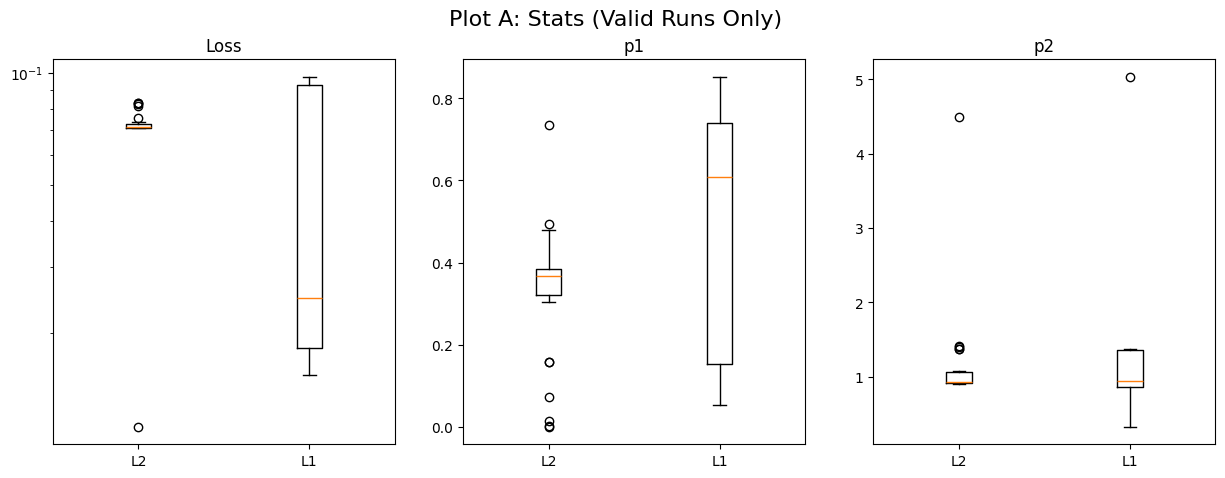

/tmp/ipykernel_126605/1028930623.py:45: RuntimeWarning: Mean of empty slice
  bootstrap_means[i] = np.nanmean(sample, axis=0)


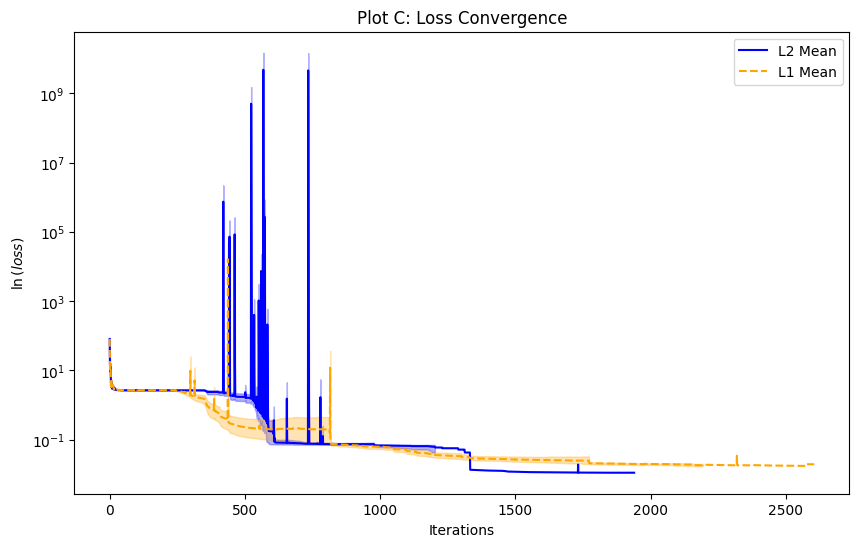

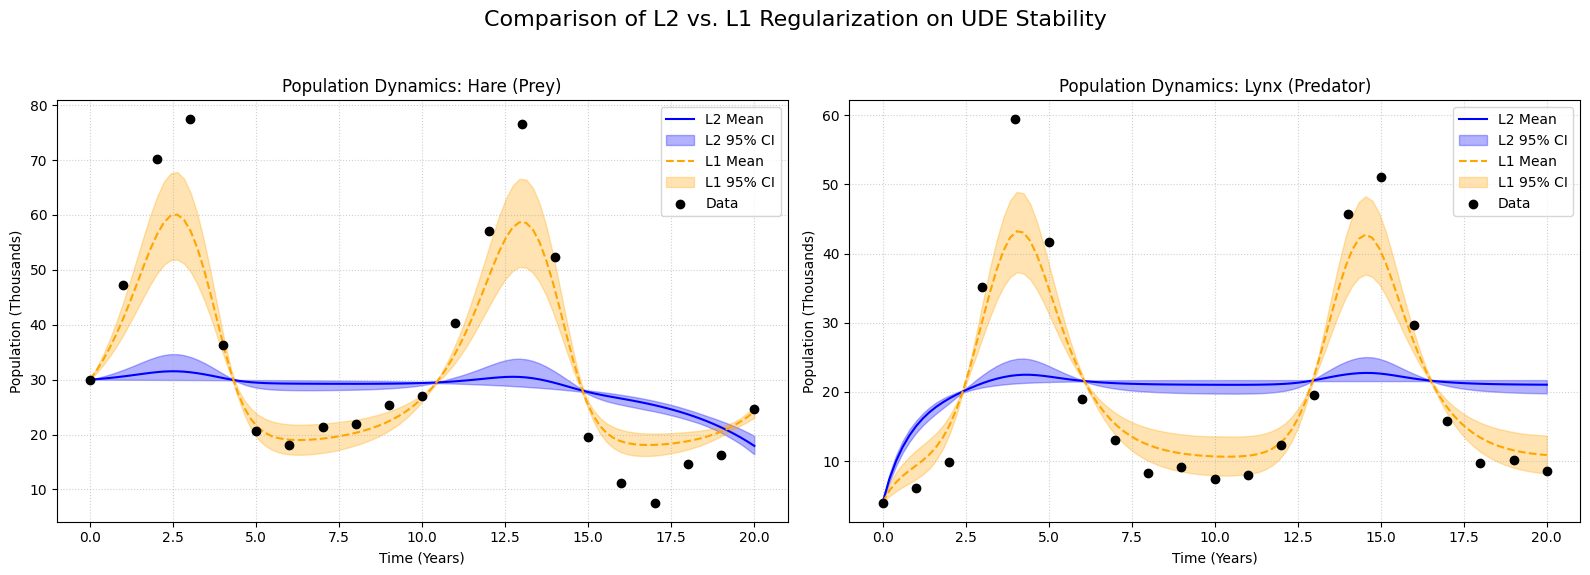

In [101]:

# ==============================================================================
# 6. PLOTTING
# ==============================================================================

# Prepare Data
loss_l2_all = pad_loss_histories(results_l2['hist'])
loss_l1_all = pad_loss_histories(results_l1['hist'])
traj_l2_all = np.array(results_l2['trajs'])
traj_l1_all = np.array(results_l1['trajs'])

print(f"\nSuccessful L2 Runs: {len(results_l2['losses'])}")
print(f"Successful L1 Runs: {len(results_l1['losses'])}")

# --- Plot A: Box Plots ---
metrics_data = {
    'L2': {'Loss': results_l2['losses'], 'p1': results_l2['p1s'], 'p2': results_l2['p2s']},
    'L1': {'Loss': results_l1['losses'], 'p1': results_l1['p1s'], 'p2': results_l1['p2s']}
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Plot A: Stats (Valid Runs Only)', fontsize=16)
labels = ['L2', 'L1']

for i, key in enumerate(['Loss', 'p1', 'p2']):
    data = [metrics_data['L2'][key], metrics_data['L1'][key]]
    axes[i].boxplot(data, labels=labels)
    axes[i].set_title(key)
    if key == 'Loss': axes[i].set_yscale('log')
plt.show()

# --- Plot C: Convergence ---
mean_loss_l2, low_loss_l2, up_loss_l2 = bootstrap_ci(loss_l2_all)
mean_loss_l1, low_loss_l1, up_loss_l1 = bootstrap_ci(loss_l1_all)
iter_l2 = np.arange(len(mean_loss_l2)) if mean_loss_l2 is not None else []
iter_l1 = np.arange(len(mean_loss_l1)) if mean_loss_l1 is not None else []

plt.figure(figsize=(10, 6))
if len(iter_l2) > 0:
    plt.plot(iter_l2, mean_loss_l2, label='L2 Mean', color='blue')
    plt.fill_between(iter_l2, low_loss_l2, up_loss_l2, alpha=0.3, color='blue')
if len(iter_l1) > 0:
    plt.plot(iter_l1, mean_loss_l1, label='L1 Mean', color='orange', linestyle='--')
    plt.fill_between(iter_l1, low_loss_l1, up_loss_l1, alpha=0.3, color='orange')
plt.yscale('log')
plt.title('Plot C: Loss Convergence')
plt.xlabel("Iterations")
plt.ylabel("$\ln{(loss)}$")
plt.legend()
plt.show()

# --- Plot B: Trajectories ---
mean_traj_l2, low_traj_l2, up_traj_l2 = bootstrap_ci(traj_l2_all)
mean_traj_l1, low_traj_l1, up_traj_l1 = bootstrap_ci(traj_l1_all)

if mean_traj_l2 is not None and mean_traj_l1 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Assuming t_plot is a defined tensor from torch.linspace
    t_plot_np = t_plot.numpy()
    
    for i, species in enumerate(['Hare (Prey)', 'Lynx (Predator)']):
        # Plotting trajectories and confidence intervals
        axes[i].plot(t_plot_np, mean_traj_l2[:, i], label='L2 Mean', color='blue')
        axes[i].fill_between(t_plot_np, low_traj_l2[:, i], up_traj_l2[:, i], alpha=0.3, color='blue', label='L2 95% CI')
        
        axes[i].plot(t_plot_np, mean_traj_l1[:, i], label='L1 Mean', color='orange', linestyle='--')
        axes[i].fill_between(t_plot_np, low_traj_l1[:, i], up_traj_l1[:, i], alpha=0.3, color='orange', label='L1 95% CI')
        
        # Plotting observation data
        # Assuming t_np and X_data_denorm are defined numpy arrays
        axes[i].scatter(t_np, X_data_denorm[:, i], color='black', label='Data', zorder=5)
        
        # --- ADDING AXIS LABELS ---
        axes[i].set_title(f'Population Dynamics: {species}')
        axes[i].set_xlabel('Time (Years)')
        axes[i].set_ylabel('Population (Thousands)') 
        # --------------------------
        
        axes[i].legend(loc='upper right')
        axes[i].grid(True, linestyle=':', alpha=0.6)
        
    fig.suptitle('Comparison of L2 vs. L1 Regularization on UDE Stability', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

# Additional Analysis

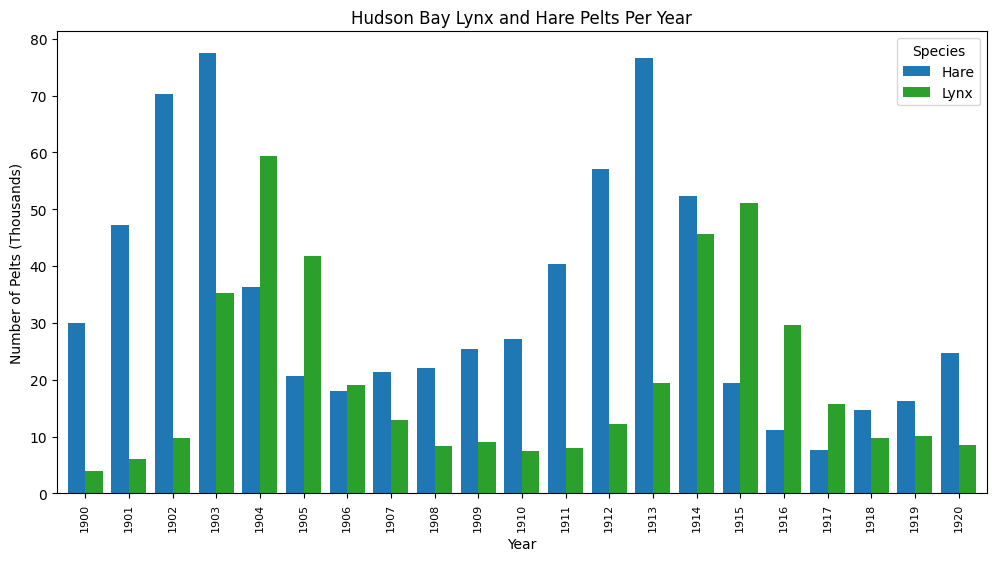

In [107]:
lynx_hare_dat = pd.DataFrame(raw_data, columns=['Year', 'Hare', 'Lynx'])
lynx_hare_dat['Year'] = lynx_hare_dat['Year'].astype(int)
lynx_hare_dat = lynx_hare_dat.set_index('Year')

# 3. Plotting Code
colors = ["#1f77b4", "#2ca02c"]
lynx_hare_dat.plot(kind="bar", color = colors, width = 0.8, figsize=(12,6))
plt.title("Hudson Bay Lynx and Hare Pelts Per Year")
# Note: Adding "(Thousands)" to the Y-axis label for context, based on previous data.
plt.ylabel("Number of Pelts (Thousands)")
plt.xlabel("Year")
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='Species')
plt.show()

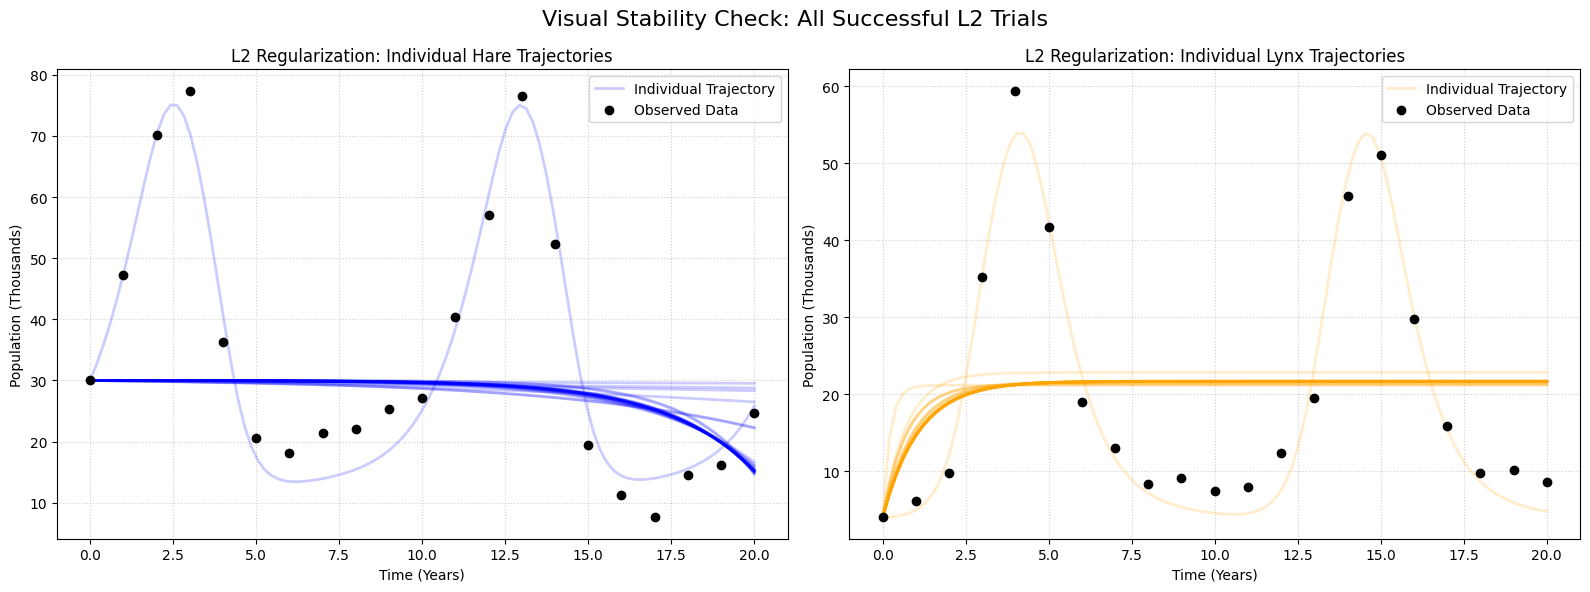

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# --- Assumptions ---
# traj_l2_all: List of successful L2 numpy trajectories (e.g., 30 items)
# traj_l1_all: List of successful L1 numpy trajectories
# t_plot_np: The dense time array (0 to 20, ~100 points)
# t_np: The sparse time array (0 to 20, 21 points)
# X_data_denorm: The raw observation data

if len(traj_l2_all) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Plotting All L2 Trajectories (Hare) ---
    for i, traj in enumerate(traj_l2_all):
        # Hare is column 0
        axes[0].plot(t_plot_np, traj[:, 0], 
                     color='blue', 
                     alpha=0.2, # Use high transparency to show density
                     linewidth=2,
                     label='Individual Trajectory' if i == 0 else None)
        
    # --- Plotting All L2 Trajectories (Lynx) ---
    for i, traj in enumerate(traj_l2_all):
        # Lynx is column 1
        axes[1].plot(t_plot_np, traj[:, 1], 
                     color='orange', 
                     alpha=0.2, # Use high transparency to show density
                     linewidth=2,
                     label='Individual Trajectory' if i == 0 else None)

    # --- Add Data and Labels to Hare Plot (Left) ---
    axes[0].scatter(t_np, X_data_denorm[:, 0], color='black', label='Observed Data', zorder=5)
    axes[0].set_title('L2 Regularization: Individual Hare Trajectories')
    axes[0].set_xlabel('Time (Years)')
    axes[0].set_ylabel('Population (Thousands)')
    axes[0].legend()
    axes[0].grid(True, linestyle=':', alpha=0.6)

    # --- Add Data and Labels to Lynx Plot (Right) ---
    axes[1].scatter(t_np, X_data_denorm[:, 1], color='black', label='Observed Data', zorder=5)
    axes[1].set_title('L2 Regularization: Individual Lynx Trajectories')
    axes[1].set_xlabel('Time (Years)')
    axes[1].set_ylabel('Population (Thousands)')
    axes[1].legend()
    axes[1].grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Visual Stability Check: All Successful L2 Trials', fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("No successful L2 trajectories found in traj_l2_all to plot.")

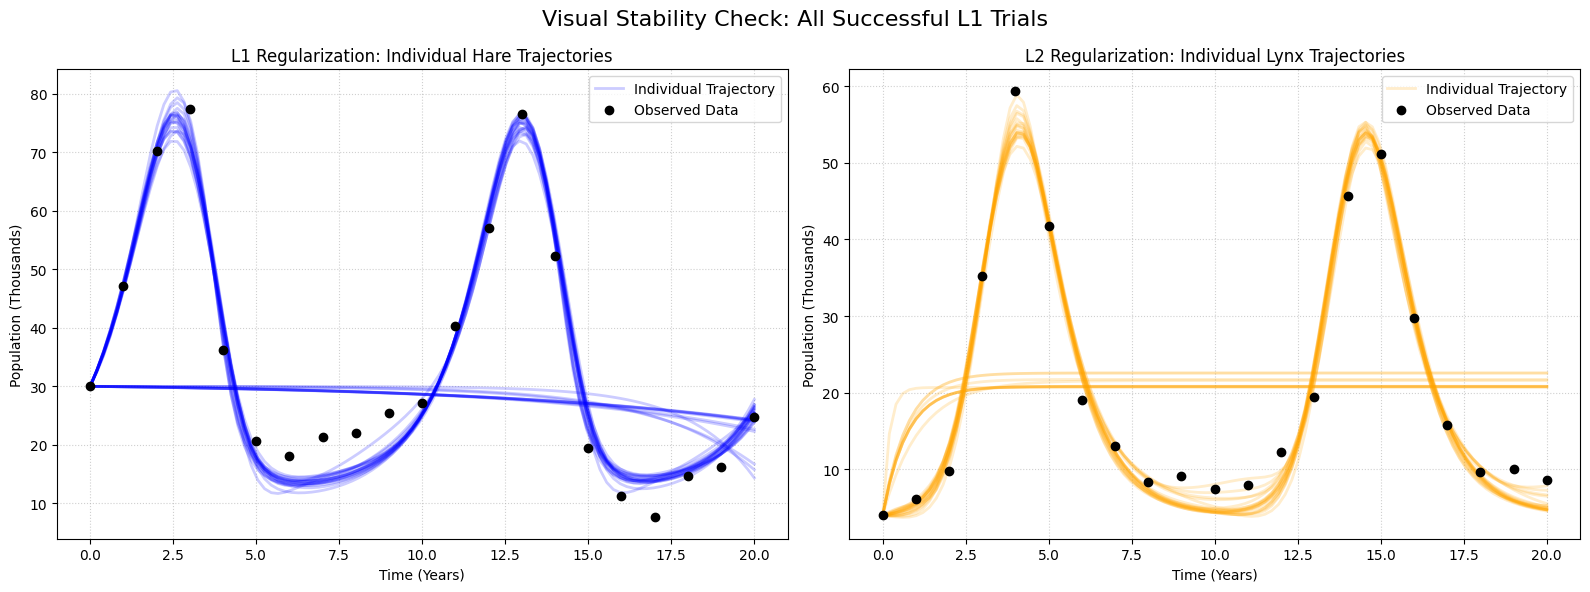

In [ ]:

if len(traj_l2_all) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Plotting All L2 Trajectories (Hare) ---
    for i, traj in enumerate(traj_l1_all):
        # Hare is column 0
        axes[0].plot(t_plot_np, traj[:, 0], 
                     color='blue', 
                     alpha=0.2, # Use high transparency to show density
                     linewidth=2,
                     label='Individual Trajectory' if i == 0 else None)
        
    # --- Plotting All L2 Trajectories (Lynx) ---
    for i, traj in enumerate(traj_l1_all):
        # Lynx is column 1
        axes[1].plot(t_plot_np, traj[:, 1], 
                     color='orange', 
                     alpha=0.2, # Use high transparency to show density
                     linewidth=2,
                     label='Individual Trajectory' if i == 0 else None)

    # --- Add Data and Labels to Hare Plot (Left) ---
    axes[0].scatter(t_np, X_data_denorm[:, 0], color='black', label='Observed Data', zorder=5)
    axes[0].set_title('L1 Regularization: Individual Hare Trajectories')
    axes[0].set_xlabel('Time (Years)')
    axes[0].set_ylabel('Population (Thousands)')
    axes[0].legend()
    axes[0].grid(True, linestyle=':', alpha=0.6)

    # --- Add Data and Labels to Lynx Plot (Right) ---
    axes[1].scatter(t_np, X_data_denorm[:, 1], color='black', label='Observed Data', zorder=5)
    axes[1].set_title('L2 Regularization: Individual Lynx Trajectories')
    axes[1].set_xlabel('Time (Years)')
    axes[1].set_ylabel('Population (Thousands)')
    axes[1].legend()
    axes[1].grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Visual Stability Check: All Successful L1 Trials', fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("No successful L2 trajectories found in traj_l2_all to plot.")

In [ ]:

def get_boxplot_stats(data_array, label):
    """Calculates the five-number summary and IQR for any array of data."""
    if data_array.ndim > 1:
        data_array = data_array.flatten()
        
    if len(data_array) == 0:
        return {
            'Parameter/Metric': label,
            'N Trials': 0,
            'Min': np.nan,
            '25th Percentile (Q1)': np.nan,
            'Median (Q2)': np.nan,
            '75th Percentile (Q3)': np.nan,
            'Max': np.nan,
            'IQR': np.nan
        }

    Q1 = np.percentile(data_array, 25)
    Q2 = np.percentile(data_array, 50)  # Median
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    return {
        'Parameter/Metric': label,
        'N Trials': len(data_array),
        'Min': np.min(data_array),
        '25th Percentile (Q1)': Q1,
        'Median (Q2)': Q2,
        '75th Percentile (Q3)': Q3,
        'Max': np.max(data_array),
        'IQR': IQR
    }

# --- Example Data (REPLACING WITH YOUR ACTUAL DATA ARRAYS) ---
np.random.seed(42)
N = 28 

# 1. Parameter Data 
p1_l2_estimates = np.random.normal(loc=0.75, scale=0.03, size=N) 
p2_l2_estimates = np.random.normal(loc=0.30, scale=0.02, size=N)
p1_l1_estimates = np.random.normal(loc=0.78, scale=0.08, size=N)
p2_l1_estimates = np.random.normal(loc=0.35, scale=0.05, size=N)

# 2. Loss Data (Example data - use raw, linear values)
np.random.seed(100)
# Ensure all loss values are positive
final_loss_l2_estimates_raw = np.abs(np.random.normal(loc=0.0005, scale=0.0001, size=N))
final_loss_l1_estimates_raw = np.abs(np.random.normal(loc=0.0008, scale=0.0003, size=N))
# ------------------------------------------------------------

# --- Calculate statistics for all six groups ---

# Loss Statistics (Linear Scaled)
stats_loss_l2 = get_boxplot_stats(final_loss_l2_estimates_raw, 'L2 Reg. Final Loss')
stats_loss_l1 = get_boxplot_stats(final_loss_l1_estimates_raw, 'L1 Reg. Final Loss')

# Parameter Statistics (Linear Scaled)
stats_p1_l2 = get_boxplot_stats(p1_l2_estimates, 'L2 Reg. $|p_1|$')
stats_p2_l2 = get_boxplot_stats(p2_l2_estimates, 'L2 Reg. $|p_2|$')
stats_p1_l1 = get_boxplot_stats(p1_l1_estimates, 'L1 Reg. $|p_1|$')
stats_p2_l1 = get_boxplot_stats(p2_l1_estimates, 'L1 Reg. $|p_2|$')

# Combine and Display as a Comparative Table
summary_df_combined = pd.DataFrame([
    stats_loss_l2, stats_p1_l2, stats_p2_l2,
    stats_loss_l1, stats_p1_l1, stats_p2_l1
]).set_index('Parameter/Metric')

# Use appropriate rounding: High precision for loss, lower for parameters
summary_df_combined = summary_df_combined.round(6) 


print("\n--- Comprehensive Summary Statistics (Loss and Parameters - LINEAR SCALE) ---")
print("Loss values are presented in their original, linear scale for direct interpretation of MSE magnitude.")
print(summary_df_combined)


--- Comprehensive Summary Statistics (Loss and Parameters - LINEAR SCALE) ---
Loss values are presented in their original, linear scale for direct interpretation of MSE magnitude.
                    N Trials       Min  25th Percentile (Q1)  Median (Q2)  \
Parameter/Metric                                                            
L2 Reg. Final Loss        28  0.000325              0.000456     0.000524   
L2 Reg. $|p_1|$           28  0.692602              0.730538     0.743101   
L2 Reg. $|p_2|$           28  0.260807              0.286247     0.295927   
L1 Reg. Final Loss        28  0.000280              0.000490     0.000636   
L1 Reg. $|p_1|$           28  0.570420              0.740884     0.782049   
L1 Reg. $|p_2|$           28  0.254061              0.324562     0.344107   

                    75th Percentile (Q3)       Max       IQR  
Parameter/Metric                                              
L2 Reg. Final Loss              0.000585  0.000662  0.000129  
L2 Reg. $|p_1